# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

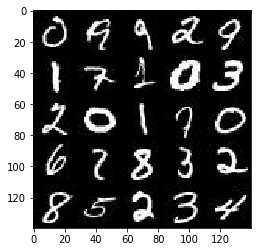

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

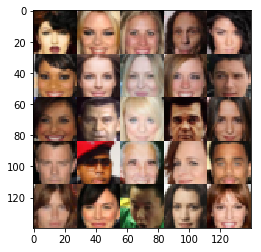

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [12]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        relu1 = tf.maximum(alpha * x1, x1)
     
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='SAME')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='SAME')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
     

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [13]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
    
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7,7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
      
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
   
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
    
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='SAME')
      
        out = tf.tanh(logits)
   
        return out



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [14]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_model = generator(input_z, out_channel_dim)
    
    dis_model_real, dis_logits_real = discriminator(input_real)
    
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse=True)
    
    dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_real, labels=tf.ones_like(dis_logits_real) * 0.9))
    
    dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.zeros_like(dis_logits_fake)))
    
    dis_loss = dis_loss_real + dis_loss_fake
    
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.ones_like(dis_logits_fake)))
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [15]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
    
    #with tf.control_dependencies(update_ops):
        
    t_vars = tf.trainable_variables()

    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
    out_channel_dim = 3 if data_image_mode == "RGB" else 1
    
    input_real, input_z, l_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    
    losses = []
    
    iteration = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                iteration += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if iteration % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    losses.append((train_loss_d, train_loss_g))
                    
                    print("Epoch {}/{}, iteration {}:".format(epoch_i + 1, epochs, iteration),
                          "Discriminator Loss: {:.4f},".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if iteration % 100 == 0:
                     show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')
        
    
    
    return losses
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2, iteration 10: Discriminator Loss: 4.6308, Generator Loss: 21.0906
Epoch 1/2, iteration 20: Discriminator Loss: 0.8322, Generator Loss: 2.5198
Epoch 1/2, iteration 30: Discriminator Loss: 1.6325, Generator Loss: 0.6623
Epoch 1/2, iteration 40: Discriminator Loss: 1.1712, Generator Loss: 1.3810
Epoch 1/2, iteration 50: Discriminator Loss: 1.8613, Generator Loss: 4.8509
Epoch 1/2, iteration 60: Discriminator Loss: 1.2189, Generator Loss: 0.8352
Epoch 1/2, iteration 70: Discriminator Loss: 1.3808, Generator Loss: 0.6353
Epoch 1/2, iteration 80: Discriminator Loss: 2.2345, Generator Loss: 4.0232
Epoch 1/2, iteration 90: Discriminator Loss: 1.0978, Generator Loss: 1.2950
Epoch 1/2, iteration 100: Discriminator Loss: 1.3777, Generator Loss: 0.5189


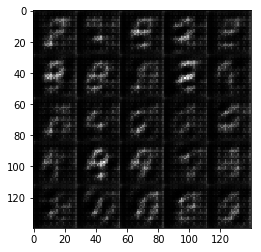

Epoch 1/2, iteration 110: Discriminator Loss: 1.4613, Generator Loss: 0.5467
Epoch 1/2, iteration 120: Discriminator Loss: 1.4458, Generator Loss: 0.5625
Epoch 1/2, iteration 130: Discriminator Loss: 1.2803, Generator Loss: 1.1328
Epoch 1/2, iteration 140: Discriminator Loss: 1.1063, Generator Loss: 0.9851
Epoch 1/2, iteration 150: Discriminator Loss: 1.2814, Generator Loss: 1.1589
Epoch 1/2, iteration 160: Discriminator Loss: 1.0905, Generator Loss: 1.3588
Epoch 1/2, iteration 170: Discriminator Loss: 1.5431, Generator Loss: 0.4469
Epoch 1/2, iteration 180: Discriminator Loss: 1.3424, Generator Loss: 0.6217
Epoch 1/2, iteration 190: Discriminator Loss: 1.2461, Generator Loss: 1.2678
Epoch 1/2, iteration 200: Discriminator Loss: 1.0876, Generator Loss: 1.1450


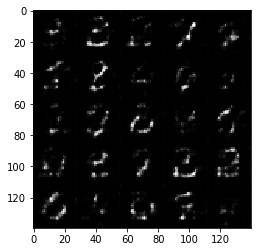

Epoch 1/2, iteration 210: Discriminator Loss: 1.2076, Generator Loss: 0.7199
Epoch 1/2, iteration 220: Discriminator Loss: 1.3475, Generator Loss: 0.5967
Epoch 1/2, iteration 230: Discriminator Loss: 1.1529, Generator Loss: 1.2457
Epoch 1/2, iteration 240: Discriminator Loss: 1.1881, Generator Loss: 0.7872
Epoch 1/2, iteration 250: Discriminator Loss: 1.1897, Generator Loss: 1.0811
Epoch 1/2, iteration 260: Discriminator Loss: 1.4378, Generator Loss: 2.2437
Epoch 1/2, iteration 270: Discriminator Loss: 1.2218, Generator Loss: 1.3698
Epoch 1/2, iteration 280: Discriminator Loss: 1.4428, Generator Loss: 2.0041
Epoch 1/2, iteration 290: Discriminator Loss: 1.2015, Generator Loss: 1.7633
Epoch 1/2, iteration 300: Discriminator Loss: 1.2113, Generator Loss: 0.7518


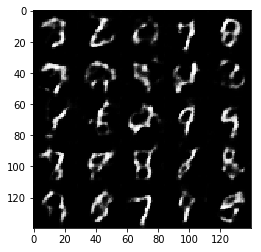

Epoch 1/2, iteration 310: Discriminator Loss: 1.1777, Generator Loss: 0.7942
Epoch 1/2, iteration 320: Discriminator Loss: 1.1630, Generator Loss: 1.0475
Epoch 1/2, iteration 330: Discriminator Loss: 1.4358, Generator Loss: 0.5248
Epoch 1/2, iteration 340: Discriminator Loss: 1.1655, Generator Loss: 0.8651
Epoch 1/2, iteration 350: Discriminator Loss: 1.2110, Generator Loss: 0.9108
Epoch 1/2, iteration 360: Discriminator Loss: 1.1500, Generator Loss: 1.0008
Epoch 1/2, iteration 370: Discriminator Loss: 1.6162, Generator Loss: 0.4400
Epoch 1/2, iteration 380: Discriminator Loss: 1.2176, Generator Loss: 0.9710
Epoch 1/2, iteration 390: Discriminator Loss: 1.1464, Generator Loss: 0.9742
Epoch 1/2, iteration 400: Discriminator Loss: 1.3932, Generator Loss: 2.0783


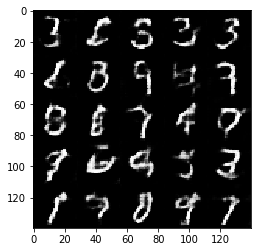

Epoch 1/2, iteration 410: Discriminator Loss: 1.2211, Generator Loss: 0.7364
Epoch 1/2, iteration 420: Discriminator Loss: 1.1225, Generator Loss: 1.0076
Epoch 1/2, iteration 430: Discriminator Loss: 1.5311, Generator Loss: 2.3524
Epoch 1/2, iteration 440: Discriminator Loss: 1.2813, Generator Loss: 1.7840
Epoch 1/2, iteration 450: Discriminator Loss: 1.1039, Generator Loss: 1.1611
Epoch 1/2, iteration 460: Discriminator Loss: 1.0946, Generator Loss: 1.2141
Epoch 2/2, iteration 470: Discriminator Loss: 1.2571, Generator Loss: 1.8991
Epoch 2/2, iteration 480: Discriminator Loss: 1.1653, Generator Loss: 0.8913
Epoch 2/2, iteration 490: Discriminator Loss: 1.3756, Generator Loss: 0.5166
Epoch 2/2, iteration 500: Discriminator Loss: 1.0417, Generator Loss: 1.1695


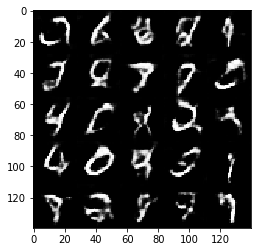

Epoch 2/2, iteration 510: Discriminator Loss: 1.2136, Generator Loss: 0.6812
Epoch 2/2, iteration 520: Discriminator Loss: 1.1718, Generator Loss: 0.9870
Epoch 2/2, iteration 530: Discriminator Loss: 1.6424, Generator Loss: 0.3937
Epoch 2/2, iteration 540: Discriminator Loss: 1.1249, Generator Loss: 0.9642
Epoch 2/2, iteration 550: Discriminator Loss: 1.0737, Generator Loss: 1.0310
Epoch 2/2, iteration 560: Discriminator Loss: 1.1472, Generator Loss: 1.1999
Epoch 2/2, iteration 570: Discriminator Loss: 1.1657, Generator Loss: 1.1724
Epoch 2/2, iteration 580: Discriminator Loss: 1.2329, Generator Loss: 1.4417
Epoch 2/2, iteration 590: Discriminator Loss: 1.1991, Generator Loss: 0.6993
Epoch 2/2, iteration 600: Discriminator Loss: 1.4248, Generator Loss: 0.5857


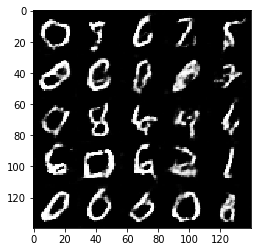

Epoch 2/2, iteration 610: Discriminator Loss: 1.0699, Generator Loss: 1.0605
Epoch 2/2, iteration 620: Discriminator Loss: 1.1295, Generator Loss: 1.2251
Epoch 2/2, iteration 630: Discriminator Loss: 1.1439, Generator Loss: 1.3478
Epoch 2/2, iteration 640: Discriminator Loss: 1.1740, Generator Loss: 1.6392
Epoch 2/2, iteration 650: Discriminator Loss: 1.0828, Generator Loss: 1.2912
Epoch 2/2, iteration 660: Discriminator Loss: 1.2192, Generator Loss: 1.5548
Epoch 2/2, iteration 670: Discriminator Loss: 1.2528, Generator Loss: 0.7075
Epoch 2/2, iteration 680: Discriminator Loss: 1.0551, Generator Loss: 1.1840
Epoch 2/2, iteration 690: Discriminator Loss: 1.3866, Generator Loss: 0.5032
Epoch 2/2, iteration 700: Discriminator Loss: 1.1013, Generator Loss: 1.3269


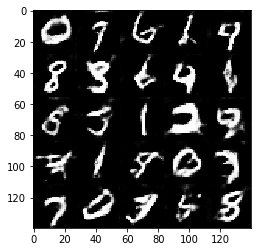

Epoch 2/2, iteration 710: Discriminator Loss: 1.1905, Generator Loss: 1.7401
Epoch 2/2, iteration 720: Discriminator Loss: 1.1973, Generator Loss: 0.7973
Epoch 2/2, iteration 730: Discriminator Loss: 1.0931, Generator Loss: 0.8444
Epoch 2/2, iteration 740: Discriminator Loss: 1.2516, Generator Loss: 1.5657
Epoch 2/2, iteration 750: Discriminator Loss: 1.1175, Generator Loss: 0.9520
Epoch 2/2, iteration 760: Discriminator Loss: 1.2064, Generator Loss: 0.8631
Epoch 2/2, iteration 770: Discriminator Loss: 1.1856, Generator Loss: 0.9557
Epoch 2/2, iteration 780: Discriminator Loss: 1.0200, Generator Loss: 1.2948
Epoch 2/2, iteration 790: Discriminator Loss: 1.1263, Generator Loss: 0.9282
Epoch 2/2, iteration 800: Discriminator Loss: 1.0850, Generator Loss: 0.8594


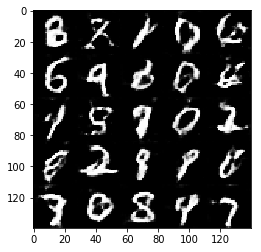

Epoch 2/2, iteration 810: Discriminator Loss: 1.6261, Generator Loss: 0.4039
Epoch 2/2, iteration 820: Discriminator Loss: 1.1874, Generator Loss: 1.3865
Epoch 2/2, iteration 830: Discriminator Loss: 1.1344, Generator Loss: 0.7115
Epoch 2/2, iteration 840: Discriminator Loss: 1.3308, Generator Loss: 0.5713
Epoch 2/2, iteration 850: Discriminator Loss: 1.0291, Generator Loss: 0.9735
Epoch 2/2, iteration 860: Discriminator Loss: 1.3332, Generator Loss: 0.5864
Epoch 2/2, iteration 870: Discriminator Loss: 1.2840, Generator Loss: 0.9841
Epoch 2/2, iteration 880: Discriminator Loss: 1.7322, Generator Loss: 0.3919
Epoch 2/2, iteration 890: Discriminator Loss: 1.1847, Generator Loss: 1.8715
Epoch 2/2, iteration 900: Discriminator Loss: 1.1858, Generator Loss: 1.5339


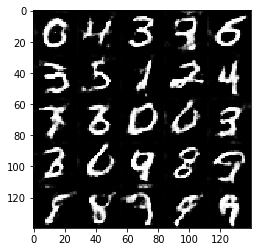

Epoch 2/2, iteration 910: Discriminator Loss: 1.0267, Generator Loss: 1.1488
Epoch 2/2, iteration 920: Discriminator Loss: 1.4589, Generator Loss: 0.4990
Epoch 2/2, iteration 930: Discriminator Loss: 1.2354, Generator Loss: 0.9800


ValueError: Parent directory of ./checkpoints/generator.ckpt doesn't exist, can't save.

In [18]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1, iteration 10: Discriminator Loss: 2.0949, Generator Loss: 0.3740
Epoch 1/1, iteration 20: Discriminator Loss: 1.2183, Generator Loss: 0.7286
Epoch 1/1, iteration 30: Discriminator Loss: 1.0543, Generator Loss: 1.0001
Epoch 1/1, iteration 40: Discriminator Loss: 0.7950, Generator Loss: 1.4266
Epoch 1/1, iteration 50: Discriminator Loss: 0.6468, Generator Loss: 1.7797
Epoch 1/1, iteration 60: Discriminator Loss: 0.9982, Generator Loss: 1.0893
Epoch 1/1, iteration 70: Discriminator Loss: 0.8119, Generator Loss: 1.5580
Epoch 1/1, iteration 80: Discriminator Loss: 0.8870, Generator Loss: 1.5611
Epoch 1/1, iteration 90: Discriminator Loss: 0.8051, Generator Loss: 1.9463
Epoch 1/1, iteration 100: Discriminator Loss: 1.1874, Generator Loss: 0.9710


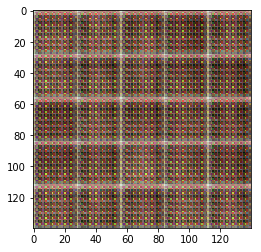

Epoch 1/1, iteration 110: Discriminator Loss: 1.1472, Generator Loss: 1.8965
Epoch 1/1, iteration 120: Discriminator Loss: 1.0419, Generator Loss: 1.1529
Epoch 1/1, iteration 130: Discriminator Loss: 0.9514, Generator Loss: 1.3808
Epoch 1/1, iteration 140: Discriminator Loss: 0.9021, Generator Loss: 1.5404
Epoch 1/1, iteration 150: Discriminator Loss: 1.0527, Generator Loss: 0.9638
Epoch 1/1, iteration 160: Discriminator Loss: 1.0933, Generator Loss: 0.8737
Epoch 1/1, iteration 170: Discriminator Loss: 1.1808, Generator Loss: 0.8714
Epoch 1/1, iteration 180: Discriminator Loss: 0.8942, Generator Loss: 1.5652
Epoch 1/1, iteration 190: Discriminator Loss: 1.0509, Generator Loss: 1.2589
Epoch 1/1, iteration 200: Discriminator Loss: 1.1035, Generator Loss: 1.2405


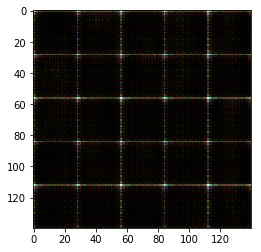

Epoch 1/1, iteration 210: Discriminator Loss: 1.1428, Generator Loss: 1.0888
Epoch 1/1, iteration 220: Discriminator Loss: 1.2243, Generator Loss: 0.9400
Epoch 1/1, iteration 230: Discriminator Loss: 1.0405, Generator Loss: 1.1561
Epoch 1/1, iteration 240: Discriminator Loss: 1.0588, Generator Loss: 1.4091
Epoch 1/1, iteration 250: Discriminator Loss: 1.1896, Generator Loss: 1.3971
Epoch 1/1, iteration 260: Discriminator Loss: 1.5363, Generator Loss: 2.3921
Epoch 1/1, iteration 270: Discriminator Loss: 1.1209, Generator Loss: 0.9400
Epoch 1/1, iteration 280: Discriminator Loss: 1.4908, Generator Loss: 0.5214
Epoch 1/1, iteration 290: Discriminator Loss: 1.1808, Generator Loss: 0.9096
Epoch 1/1, iteration 300: Discriminator Loss: 1.3656, Generator Loss: 1.3721


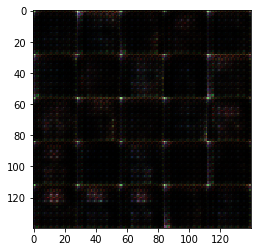

Epoch 1/1, iteration 310: Discriminator Loss: 1.0851, Generator Loss: 1.1067
Epoch 1/1, iteration 320: Discriminator Loss: 1.1676, Generator Loss: 0.8229
Epoch 1/1, iteration 330: Discriminator Loss: 1.1873, Generator Loss: 0.7627
Epoch 1/1, iteration 340: Discriminator Loss: 1.2163, Generator Loss: 2.1519
Epoch 1/1, iteration 350: Discriminator Loss: 1.0936, Generator Loss: 1.1671
Epoch 1/1, iteration 360: Discriminator Loss: 1.1219, Generator Loss: 0.9319
Epoch 1/1, iteration 370: Discriminator Loss: 1.3712, Generator Loss: 0.7724
Epoch 1/1, iteration 380: Discriminator Loss: 1.1959, Generator Loss: 0.8463
Epoch 1/1, iteration 390: Discriminator Loss: 1.0020, Generator Loss: 1.1568
Epoch 1/1, iteration 400: Discriminator Loss: 1.4498, Generator Loss: 0.6235


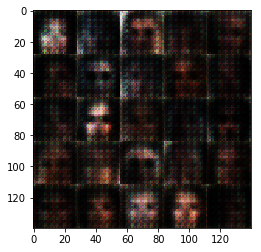

Epoch 1/1, iteration 410: Discriminator Loss: 1.2453, Generator Loss: 0.9252
Epoch 1/1, iteration 420: Discriminator Loss: 1.1886, Generator Loss: 0.8871
Epoch 1/1, iteration 430: Discriminator Loss: 1.2034, Generator Loss: 0.9177
Epoch 1/1, iteration 440: Discriminator Loss: 1.3033, Generator Loss: 1.1404
Epoch 1/1, iteration 450: Discriminator Loss: 1.3490, Generator Loss: 0.7369
Epoch 1/1, iteration 460: Discriminator Loss: 1.2744, Generator Loss: 1.1488
Epoch 1/1, iteration 470: Discriminator Loss: 1.3755, Generator Loss: 1.1925
Epoch 1/1, iteration 480: Discriminator Loss: 1.3570, Generator Loss: 1.0672
Epoch 1/1, iteration 490: Discriminator Loss: 1.2316, Generator Loss: 1.2343
Epoch 1/1, iteration 500: Discriminator Loss: 1.2868, Generator Loss: 0.9378


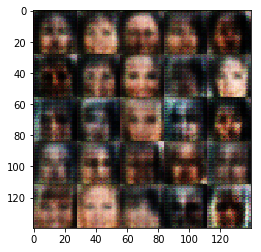

Epoch 1/1, iteration 510: Discriminator Loss: 1.1367, Generator Loss: 0.9975
Epoch 1/1, iteration 520: Discriminator Loss: 1.2600, Generator Loss: 0.8118
Epoch 1/1, iteration 530: Discriminator Loss: 1.3434, Generator Loss: 0.9076
Epoch 1/1, iteration 540: Discriminator Loss: 1.2179, Generator Loss: 0.8746
Epoch 1/1, iteration 550: Discriminator Loss: 1.2359, Generator Loss: 0.8874
Epoch 1/1, iteration 560: Discriminator Loss: 1.2811, Generator Loss: 0.8203
Epoch 1/1, iteration 570: Discriminator Loss: 1.2130, Generator Loss: 0.9982
Epoch 1/1, iteration 580: Discriminator Loss: 1.4255, Generator Loss: 0.7264
Epoch 1/1, iteration 590: Discriminator Loss: 1.4230, Generator Loss: 0.9714
Epoch 1/1, iteration 600: Discriminator Loss: 1.3535, Generator Loss: 1.0678


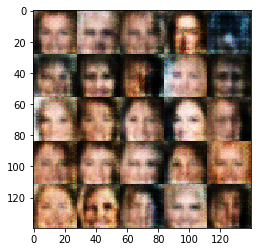

Epoch 1/1, iteration 610: Discriminator Loss: 1.4038, Generator Loss: 0.7841
Epoch 1/1, iteration 620: Discriminator Loss: 1.1835, Generator Loss: 0.9136
Epoch 1/1, iteration 630: Discriminator Loss: 1.4644, Generator Loss: 0.8966
Epoch 1/1, iteration 640: Discriminator Loss: 1.3185, Generator Loss: 1.0170
Epoch 1/1, iteration 650: Discriminator Loss: 1.2931, Generator Loss: 0.7375
Epoch 1/1, iteration 660: Discriminator Loss: 1.2602, Generator Loss: 1.0010
Epoch 1/1, iteration 670: Discriminator Loss: 1.4245, Generator Loss: 0.8295
Epoch 1/1, iteration 680: Discriminator Loss: 1.1795, Generator Loss: 1.0487
Epoch 1/1, iteration 690: Discriminator Loss: 1.1732, Generator Loss: 1.0380
Epoch 1/1, iteration 700: Discriminator Loss: 1.2920, Generator Loss: 0.9838


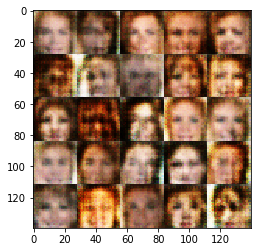

Epoch 1/1, iteration 710: Discriminator Loss: 1.3494, Generator Loss: 0.9304
Epoch 1/1, iteration 720: Discriminator Loss: 1.4016, Generator Loss: 0.7709
Epoch 1/1, iteration 730: Discriminator Loss: 1.4676, Generator Loss: 0.7890
Epoch 1/1, iteration 740: Discriminator Loss: 1.4149, Generator Loss: 0.6995
Epoch 1/1, iteration 750: Discriminator Loss: 1.3228, Generator Loss: 0.9308
Epoch 1/1, iteration 760: Discriminator Loss: 1.2667, Generator Loss: 0.9103
Epoch 1/1, iteration 770: Discriminator Loss: 1.3130, Generator Loss: 1.0026
Epoch 1/1, iteration 780: Discriminator Loss: 1.3731, Generator Loss: 0.8731
Epoch 1/1, iteration 790: Discriminator Loss: 1.1708, Generator Loss: 0.9986
Epoch 1/1, iteration 800: Discriminator Loss: 1.2866, Generator Loss: 0.9290


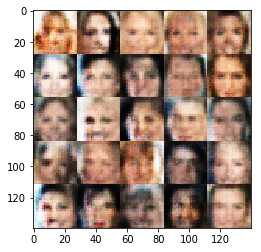

Epoch 1/1, iteration 810: Discriminator Loss: 1.2515, Generator Loss: 0.8173
Epoch 1/1, iteration 820: Discriminator Loss: 1.1959, Generator Loss: 1.0022
Epoch 1/1, iteration 830: Discriminator Loss: 1.3003, Generator Loss: 0.9128
Epoch 1/1, iteration 840: Discriminator Loss: 1.2695, Generator Loss: 0.8952
Epoch 1/1, iteration 850: Discriminator Loss: 1.2460, Generator Loss: 0.8139
Epoch 1/1, iteration 860: Discriminator Loss: 1.3762, Generator Loss: 1.2977
Epoch 1/1, iteration 870: Discriminator Loss: 1.2154, Generator Loss: 0.8771
Epoch 1/1, iteration 880: Discriminator Loss: 1.3226, Generator Loss: 0.7667
Epoch 1/1, iteration 890: Discriminator Loss: 1.3460, Generator Loss: 0.7848
Epoch 1/1, iteration 900: Discriminator Loss: 1.3463, Generator Loss: 0.8201


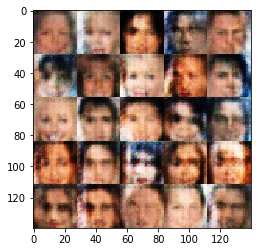

Epoch 1/1, iteration 910: Discriminator Loss: 1.2970, Generator Loss: 1.2089
Epoch 1/1, iteration 920: Discriminator Loss: 1.2112, Generator Loss: 0.9715
Epoch 1/1, iteration 930: Discriminator Loss: 1.3322, Generator Loss: 0.7744
Epoch 1/1, iteration 940: Discriminator Loss: 1.3692, Generator Loss: 0.9544
Epoch 1/1, iteration 950: Discriminator Loss: 1.4936, Generator Loss: 0.7946
Epoch 1/1, iteration 960: Discriminator Loss: 1.2519, Generator Loss: 1.0739
Epoch 1/1, iteration 970: Discriminator Loss: 1.2983, Generator Loss: 0.7460
Epoch 1/1, iteration 980: Discriminator Loss: 1.3030, Generator Loss: 0.8586
Epoch 1/1, iteration 990: Discriminator Loss: 1.2022, Generator Loss: 0.9959
Epoch 1/1, iteration 1000: Discriminator Loss: 1.2399, Generator Loss: 0.9621


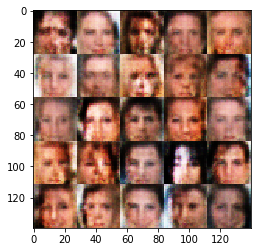

Epoch 1/1, iteration 1010: Discriminator Loss: 1.4227, Generator Loss: 0.9515
Epoch 1/1, iteration 1020: Discriminator Loss: 1.2528, Generator Loss: 0.9470
Epoch 1/1, iteration 1030: Discriminator Loss: 1.4254, Generator Loss: 0.8333
Epoch 1/1, iteration 1040: Discriminator Loss: 1.1417, Generator Loss: 0.9572
Epoch 1/1, iteration 1050: Discriminator Loss: 1.2801, Generator Loss: 0.7753
Epoch 1/1, iteration 1060: Discriminator Loss: 1.3265, Generator Loss: 0.8630
Epoch 1/1, iteration 1070: Discriminator Loss: 1.4508, Generator Loss: 0.6571
Epoch 1/1, iteration 1080: Discriminator Loss: 1.2052, Generator Loss: 0.9402
Epoch 1/1, iteration 1090: Discriminator Loss: 1.2588, Generator Loss: 0.9739
Epoch 1/1, iteration 1100: Discriminator Loss: 1.3058, Generator Loss: 0.8483


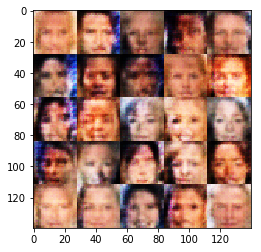

Epoch 1/1, iteration 1110: Discriminator Loss: 1.2556, Generator Loss: 0.9647
Epoch 1/1, iteration 1120: Discriminator Loss: 1.4091, Generator Loss: 0.6865
Epoch 1/1, iteration 1130: Discriminator Loss: 1.3674, Generator Loss: 0.9325
Epoch 1/1, iteration 1140: Discriminator Loss: 1.1960, Generator Loss: 0.9542
Epoch 1/1, iteration 1150: Discriminator Loss: 1.1995, Generator Loss: 1.1686
Epoch 1/1, iteration 1160: Discriminator Loss: 1.3886, Generator Loss: 0.8120
Epoch 1/1, iteration 1170: Discriminator Loss: 1.3115, Generator Loss: 0.9656
Epoch 1/1, iteration 1180: Discriminator Loss: 1.3385, Generator Loss: 0.7256
Epoch 1/1, iteration 1190: Discriminator Loss: 1.3736, Generator Loss: 0.7841
Epoch 1/1, iteration 1200: Discriminator Loss: 1.3165, Generator Loss: 1.0882


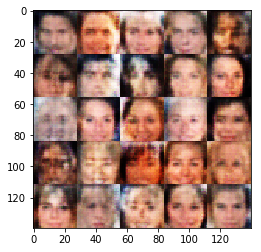

Epoch 1/1, iteration 1210: Discriminator Loss: 1.4326, Generator Loss: 0.7099
Epoch 1/1, iteration 1220: Discriminator Loss: 1.2342, Generator Loss: 1.0478
Epoch 1/1, iteration 1230: Discriminator Loss: 1.3246, Generator Loss: 0.7140
Epoch 1/1, iteration 1240: Discriminator Loss: 1.2929, Generator Loss: 0.9034
Epoch 1/1, iteration 1250: Discriminator Loss: 1.4031, Generator Loss: 1.0508
Epoch 1/1, iteration 1260: Discriminator Loss: 1.4483, Generator Loss: 0.9192
Epoch 1/1, iteration 1270: Discriminator Loss: 1.2512, Generator Loss: 0.9346
Epoch 1/1, iteration 1280: Discriminator Loss: 1.3935, Generator Loss: 0.6134
Epoch 1/1, iteration 1290: Discriminator Loss: 1.3808, Generator Loss: 0.6894
Epoch 1/1, iteration 1300: Discriminator Loss: 1.2584, Generator Loss: 0.8512


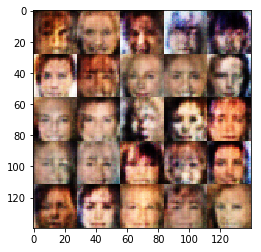

Epoch 1/1, iteration 1310: Discriminator Loss: 1.3463, Generator Loss: 0.7665
Epoch 1/1, iteration 1320: Discriminator Loss: 1.3110, Generator Loss: 0.8346
Epoch 1/1, iteration 1330: Discriminator Loss: 1.3820, Generator Loss: 0.7463
Epoch 1/1, iteration 1340: Discriminator Loss: 1.2845, Generator Loss: 0.8427
Epoch 1/1, iteration 1350: Discriminator Loss: 1.2133, Generator Loss: 0.9453
Epoch 1/1, iteration 1360: Discriminator Loss: 1.3019, Generator Loss: 0.8627
Epoch 1/1, iteration 1370: Discriminator Loss: 1.2143, Generator Loss: 1.0849
Epoch 1/1, iteration 1380: Discriminator Loss: 1.3238, Generator Loss: 0.8421
Epoch 1/1, iteration 1390: Discriminator Loss: 1.2940, Generator Loss: 0.9927
Epoch 1/1, iteration 1400: Discriminator Loss: 1.3136, Generator Loss: 0.9779


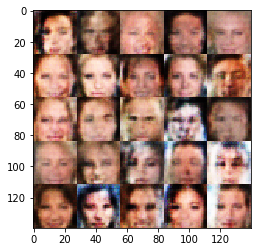

Epoch 1/1, iteration 1410: Discriminator Loss: 1.2854, Generator Loss: 0.8738
Epoch 1/1, iteration 1420: Discriminator Loss: 1.1981, Generator Loss: 0.9005
Epoch 1/1, iteration 1430: Discriminator Loss: 1.2826, Generator Loss: 0.8250
Epoch 1/1, iteration 1440: Discriminator Loss: 1.2676, Generator Loss: 0.8053
Epoch 1/1, iteration 1450: Discriminator Loss: 1.3540, Generator Loss: 0.6797
Epoch 1/1, iteration 1460: Discriminator Loss: 1.2858, Generator Loss: 0.8757
Epoch 1/1, iteration 1470: Discriminator Loss: 1.2133, Generator Loss: 1.2002
Epoch 1/1, iteration 1480: Discriminator Loss: 1.2970, Generator Loss: 0.8539
Epoch 1/1, iteration 1490: Discriminator Loss: 1.2762, Generator Loss: 0.9230
Epoch 1/1, iteration 1500: Discriminator Loss: 1.3463, Generator Loss: 0.7986


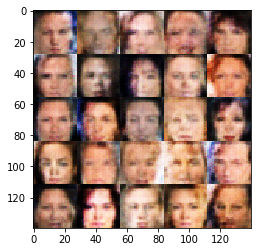

Epoch 1/1, iteration 1510: Discriminator Loss: 1.2549, Generator Loss: 0.8958
Epoch 1/1, iteration 1520: Discriminator Loss: 1.2270, Generator Loss: 0.7919
Epoch 1/1, iteration 1530: Discriminator Loss: 1.2199, Generator Loss: 0.9714
Epoch 1/1, iteration 1540: Discriminator Loss: 1.2591, Generator Loss: 0.8183
Epoch 1/1, iteration 1550: Discriminator Loss: 1.4152, Generator Loss: 0.8318
Epoch 1/1, iteration 1560: Discriminator Loss: 1.3864, Generator Loss: 0.8402
Epoch 1/1, iteration 1570: Discriminator Loss: 1.2513, Generator Loss: 0.9166
Epoch 1/1, iteration 1580: Discriminator Loss: 1.3157, Generator Loss: 0.7068
Epoch 1/1, iteration 1590: Discriminator Loss: 1.3620, Generator Loss: 0.7280
Epoch 1/1, iteration 1600: Discriminator Loss: 1.2581, Generator Loss: 0.8998


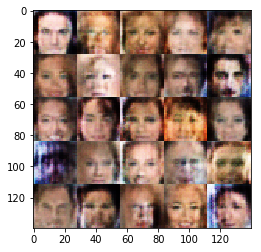

Epoch 1/1, iteration 1610: Discriminator Loss: 1.2180, Generator Loss: 1.0089
Epoch 1/1, iteration 1620: Discriminator Loss: 1.3613, Generator Loss: 0.7841
Epoch 1/1, iteration 1630: Discriminator Loss: 1.4141, Generator Loss: 0.7329
Epoch 1/1, iteration 1640: Discriminator Loss: 1.3758, Generator Loss: 0.7948
Epoch 1/1, iteration 1650: Discriminator Loss: 1.3511, Generator Loss: 0.6377
Epoch 1/1, iteration 1660: Discriminator Loss: 1.2568, Generator Loss: 0.8408
Epoch 1/1, iteration 1670: Discriminator Loss: 1.2026, Generator Loss: 0.9607
Epoch 1/1, iteration 1680: Discriminator Loss: 1.3874, Generator Loss: 0.6434
Epoch 1/1, iteration 1690: Discriminator Loss: 1.2252, Generator Loss: 0.8729
Epoch 1/1, iteration 1700: Discriminator Loss: 1.2824, Generator Loss: 0.8031


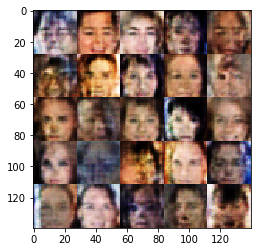

Epoch 1/1, iteration 1710: Discriminator Loss: 1.3334, Generator Loss: 0.8147
Epoch 1/1, iteration 1720: Discriminator Loss: 1.1353, Generator Loss: 0.9239
Epoch 1/1, iteration 1730: Discriminator Loss: 1.2956, Generator Loss: 0.7236
Epoch 1/1, iteration 1740: Discriminator Loss: 1.2002, Generator Loss: 1.1117
Epoch 1/1, iteration 1750: Discriminator Loss: 1.3897, Generator Loss: 0.6635
Epoch 1/1, iteration 1760: Discriminator Loss: 1.3082, Generator Loss: 0.9308
Epoch 1/1, iteration 1770: Discriminator Loss: 1.1509, Generator Loss: 1.0002
Epoch 1/1, iteration 1780: Discriminator Loss: 1.1487, Generator Loss: 1.0056
Epoch 1/1, iteration 1790: Discriminator Loss: 1.2510, Generator Loss: 0.9373
Epoch 1/1, iteration 1800: Discriminator Loss: 1.2695, Generator Loss: 0.7454


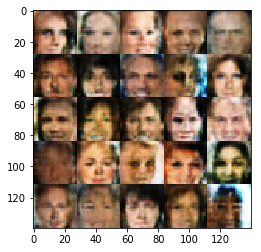

Epoch 1/1, iteration 1810: Discriminator Loss: 1.3137, Generator Loss: 0.7564
Epoch 1/1, iteration 1820: Discriminator Loss: 1.1199, Generator Loss: 1.2350
Epoch 1/1, iteration 1830: Discriminator Loss: 1.3257, Generator Loss: 0.8684
Epoch 1/1, iteration 1840: Discriminator Loss: 1.2010, Generator Loss: 0.9384
Epoch 1/1, iteration 1850: Discriminator Loss: 1.2667, Generator Loss: 0.7926
Epoch 1/1, iteration 1860: Discriminator Loss: 1.3387, Generator Loss: 0.8364
Epoch 1/1, iteration 1870: Discriminator Loss: 1.2197, Generator Loss: 0.9523
Epoch 1/1, iteration 1880: Discriminator Loss: 1.2584, Generator Loss: 0.8629
Epoch 1/1, iteration 1890: Discriminator Loss: 1.2138, Generator Loss: 1.1513
Epoch 1/1, iteration 1900: Discriminator Loss: 1.2077, Generator Loss: 1.1053


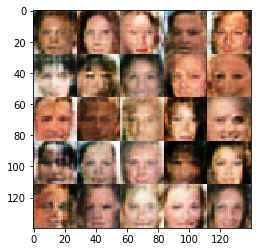

Epoch 1/1, iteration 1910: Discriminator Loss: 1.2333, Generator Loss: 0.9475
Epoch 1/1, iteration 1920: Discriminator Loss: 1.1355, Generator Loss: 0.9645
Epoch 1/1, iteration 1930: Discriminator Loss: 1.1662, Generator Loss: 0.9682
Epoch 1/1, iteration 1940: Discriminator Loss: 1.2180, Generator Loss: 0.8764
Epoch 1/1, iteration 1950: Discriminator Loss: 1.2769, Generator Loss: 0.7852
Epoch 1/1, iteration 1960: Discriminator Loss: 1.2623, Generator Loss: 0.8240
Epoch 1/1, iteration 1970: Discriminator Loss: 1.3397, Generator Loss: 0.7635
Epoch 1/1, iteration 1980: Discriminator Loss: 1.3280, Generator Loss: 0.8380
Epoch 1/1, iteration 1990: Discriminator Loss: 1.2279, Generator Loss: 0.8739
Epoch 1/1, iteration 2000: Discriminator Loss: 1.1916, Generator Loss: 0.7874


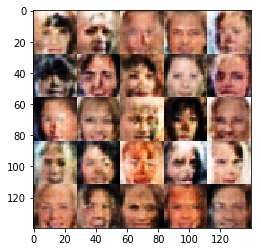

Epoch 1/1, iteration 2010: Discriminator Loss: 1.3752, Generator Loss: 0.9451
Epoch 1/1, iteration 2020: Discriminator Loss: 1.1346, Generator Loss: 1.0449
Epoch 1/1, iteration 2030: Discriminator Loss: 1.1835, Generator Loss: 0.8334
Epoch 1/1, iteration 2040: Discriminator Loss: 1.2316, Generator Loss: 0.7971
Epoch 1/1, iteration 2050: Discriminator Loss: 1.1719, Generator Loss: 1.1159
Epoch 1/1, iteration 2060: Discriminator Loss: 1.1165, Generator Loss: 0.9373
Epoch 1/1, iteration 2070: Discriminator Loss: 1.3356, Generator Loss: 0.7630
Epoch 1/1, iteration 2080: Discriminator Loss: 1.2162, Generator Loss: 0.9450
Epoch 1/1, iteration 2090: Discriminator Loss: 1.1884, Generator Loss: 0.9049
Epoch 1/1, iteration 2100: Discriminator Loss: 1.4988, Generator Loss: 0.6432


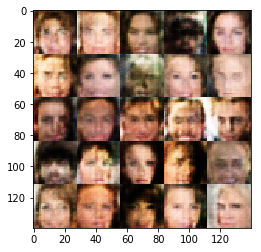

Epoch 1/1, iteration 2110: Discriminator Loss: 1.5434, Generator Loss: 0.5417
Epoch 1/1, iteration 2120: Discriminator Loss: 1.1764, Generator Loss: 1.0153
Epoch 1/1, iteration 2130: Discriminator Loss: 1.2096, Generator Loss: 1.0012
Epoch 1/1, iteration 2140: Discriminator Loss: 1.2293, Generator Loss: 1.0153
Epoch 1/1, iteration 2150: Discriminator Loss: 1.2694, Generator Loss: 0.7472
Epoch 1/1, iteration 2160: Discriminator Loss: 1.1671, Generator Loss: 0.9517
Epoch 1/1, iteration 2170: Discriminator Loss: 1.2496, Generator Loss: 1.0857
Epoch 1/1, iteration 2180: Discriminator Loss: 1.3928, Generator Loss: 0.6533
Epoch 1/1, iteration 2190: Discriminator Loss: 1.3861, Generator Loss: 0.7393
Epoch 1/1, iteration 2200: Discriminator Loss: 1.3370, Generator Loss: 0.9938


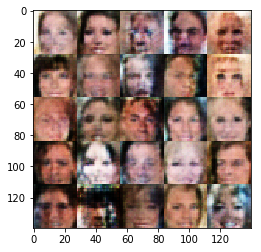

Epoch 1/1, iteration 2210: Discriminator Loss: 1.3060, Generator Loss: 0.8570
Epoch 1/1, iteration 2220: Discriminator Loss: 1.0332, Generator Loss: 1.1319
Epoch 1/1, iteration 2230: Discriminator Loss: 1.2496, Generator Loss: 0.8379
Epoch 1/1, iteration 2240: Discriminator Loss: 1.3897, Generator Loss: 0.6655
Epoch 1/1, iteration 2250: Discriminator Loss: 1.1896, Generator Loss: 0.8977
Epoch 1/1, iteration 2260: Discriminator Loss: 1.3005, Generator Loss: 0.7815
Epoch 1/1, iteration 2270: Discriminator Loss: 1.1468, Generator Loss: 0.8835
Epoch 1/1, iteration 2280: Discriminator Loss: 1.2970, Generator Loss: 0.6609
Epoch 1/1, iteration 2290: Discriminator Loss: 1.2860, Generator Loss: 0.8627
Epoch 1/1, iteration 2300: Discriminator Loss: 1.4840, Generator Loss: 0.7110


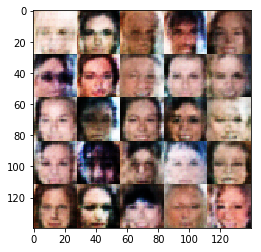

Epoch 1/1, iteration 2310: Discriminator Loss: 1.2167, Generator Loss: 1.0506
Epoch 1/1, iteration 2320: Discriminator Loss: 1.3711, Generator Loss: 0.7668
Epoch 1/1, iteration 2330: Discriminator Loss: 1.4583, Generator Loss: 0.8070
Epoch 1/1, iteration 2340: Discriminator Loss: 1.3234, Generator Loss: 0.9166
Epoch 1/1, iteration 2350: Discriminator Loss: 1.3494, Generator Loss: 0.7263
Epoch 1/1, iteration 2360: Discriminator Loss: 1.3258, Generator Loss: 0.7330
Epoch 1/1, iteration 2370: Discriminator Loss: 1.3348, Generator Loss: 0.8262
Epoch 1/1, iteration 2380: Discriminator Loss: 1.2297, Generator Loss: 0.7783
Epoch 1/1, iteration 2390: Discriminator Loss: 1.2024, Generator Loss: 0.8837
Epoch 1/1, iteration 2400: Discriminator Loss: 1.2771, Generator Loss: 0.6749


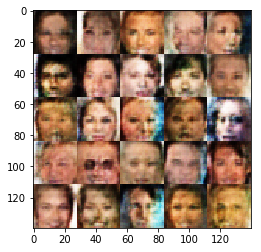

Epoch 1/1, iteration 2410: Discriminator Loss: 1.1993, Generator Loss: 0.8637
Epoch 1/1, iteration 2420: Discriminator Loss: 0.9810, Generator Loss: 1.4599
Epoch 1/1, iteration 2430: Discriminator Loss: 1.3328, Generator Loss: 0.7591
Epoch 1/1, iteration 2440: Discriminator Loss: 1.1751, Generator Loss: 1.0222
Epoch 1/1, iteration 2450: Discriminator Loss: 1.1935, Generator Loss: 0.8104
Epoch 1/1, iteration 2460: Discriminator Loss: 1.2872, Generator Loss: 0.6811
Epoch 1/1, iteration 2470: Discriminator Loss: 1.4547, Generator Loss: 0.6163
Epoch 1/1, iteration 2480: Discriminator Loss: 1.2115, Generator Loss: 0.8627
Epoch 1/1, iteration 2490: Discriminator Loss: 1.3256, Generator Loss: 0.8813
Epoch 1/1, iteration 2500: Discriminator Loss: 1.1555, Generator Loss: 1.0385


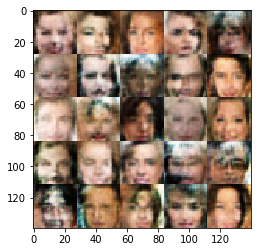

Epoch 1/1, iteration 2510: Discriminator Loss: 1.5048, Generator Loss: 0.8044
Epoch 1/1, iteration 2520: Discriminator Loss: 1.2960, Generator Loss: 0.8256
Epoch 1/1, iteration 2530: Discriminator Loss: 1.2837, Generator Loss: 0.7231
Epoch 1/1, iteration 2540: Discriminator Loss: 1.2396, Generator Loss: 0.8226
Epoch 1/1, iteration 2550: Discriminator Loss: 1.1095, Generator Loss: 1.0816
Epoch 1/1, iteration 2560: Discriminator Loss: 1.3549, Generator Loss: 0.8941
Epoch 1/1, iteration 2570: Discriminator Loss: 1.3761, Generator Loss: 1.4439
Epoch 1/1, iteration 2580: Discriminator Loss: 1.4019, Generator Loss: 0.6013
Epoch 1/1, iteration 2590: Discriminator Loss: 1.3820, Generator Loss: 0.6737
Epoch 1/1, iteration 2600: Discriminator Loss: 1.2406, Generator Loss: 0.9497


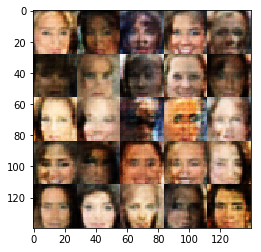

Epoch 1/1, iteration 2610: Discriminator Loss: 1.3309, Generator Loss: 0.9360
Epoch 1/1, iteration 2620: Discriminator Loss: 1.2094, Generator Loss: 0.8940
Epoch 1/1, iteration 2630: Discriminator Loss: 1.2847, Generator Loss: 0.7305
Epoch 1/1, iteration 2640: Discriminator Loss: 1.0932, Generator Loss: 1.0815
Epoch 1/1, iteration 2650: Discriminator Loss: 1.3285, Generator Loss: 0.7665
Epoch 1/1, iteration 2660: Discriminator Loss: 1.2000, Generator Loss: 1.0813
Epoch 1/1, iteration 2670: Discriminator Loss: 1.2928, Generator Loss: 0.8340
Epoch 1/1, iteration 2680: Discriminator Loss: 1.3225, Generator Loss: 0.7444
Epoch 1/1, iteration 2690: Discriminator Loss: 1.3496, Generator Loss: 0.7680
Epoch 1/1, iteration 2700: Discriminator Loss: 1.3194, Generator Loss: 0.6931


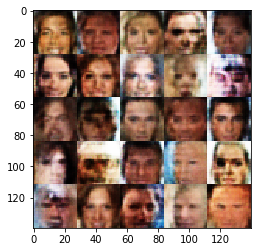

Epoch 1/1, iteration 2710: Discriminator Loss: 1.1140, Generator Loss: 1.0025
Epoch 1/1, iteration 2720: Discriminator Loss: 1.2299, Generator Loss: 0.8169
Epoch 1/1, iteration 2730: Discriminator Loss: 1.4772, Generator Loss: 0.5993
Epoch 1/1, iteration 2740: Discriminator Loss: 1.3041, Generator Loss: 0.9305
Epoch 1/1, iteration 2750: Discriminator Loss: 1.2567, Generator Loss: 1.0027
Epoch 1/1, iteration 2760: Discriminator Loss: 1.3579, Generator Loss: 0.7732
Epoch 1/1, iteration 2770: Discriminator Loss: 1.2953, Generator Loss: 0.9775
Epoch 1/1, iteration 2780: Discriminator Loss: 1.2990, Generator Loss: 0.7261
Epoch 1/1, iteration 2790: Discriminator Loss: 1.2221, Generator Loss: 0.9511
Epoch 1/1, iteration 2800: Discriminator Loss: 1.2897, Generator Loss: 0.7942


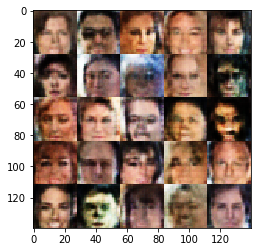

Epoch 1/1, iteration 2810: Discriminator Loss: 1.2244, Generator Loss: 0.7959
Epoch 1/1, iteration 2820: Discriminator Loss: 1.2583, Generator Loss: 0.7517
Epoch 1/1, iteration 2830: Discriminator Loss: 1.2528, Generator Loss: 0.8963
Epoch 1/1, iteration 2840: Discriminator Loss: 1.1510, Generator Loss: 0.9055
Epoch 1/1, iteration 2850: Discriminator Loss: 1.3923, Generator Loss: 0.7701
Epoch 1/1, iteration 2860: Discriminator Loss: 1.3643, Generator Loss: 0.8456
Epoch 1/1, iteration 2870: Discriminator Loss: 1.3143, Generator Loss: 0.8530
Epoch 1/1, iteration 2880: Discriminator Loss: 1.1353, Generator Loss: 1.1234
Epoch 1/1, iteration 2890: Discriminator Loss: 1.1646, Generator Loss: 1.3462
Epoch 1/1, iteration 2900: Discriminator Loss: 1.3370, Generator Loss: 0.7849


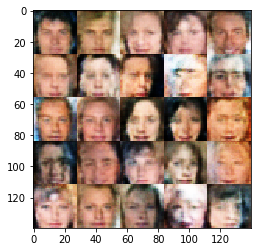

Epoch 1/1, iteration 2910: Discriminator Loss: 1.2623, Generator Loss: 0.7717
Epoch 1/1, iteration 2920: Discriminator Loss: 1.2404, Generator Loss: 0.9167
Epoch 1/1, iteration 2930: Discriminator Loss: 1.3858, Generator Loss: 0.7525
Epoch 1/1, iteration 2940: Discriminator Loss: 1.1871, Generator Loss: 0.8628
Epoch 1/1, iteration 2950: Discriminator Loss: 1.2202, Generator Loss: 0.9729
Epoch 1/1, iteration 2960: Discriminator Loss: 1.2051, Generator Loss: 1.0178
Epoch 1/1, iteration 2970: Discriminator Loss: 1.2097, Generator Loss: 1.1873
Epoch 1/1, iteration 2980: Discriminator Loss: 1.2515, Generator Loss: 0.8749
Epoch 1/1, iteration 2990: Discriminator Loss: 1.1756, Generator Loss: 0.8924
Epoch 1/1, iteration 3000: Discriminator Loss: 1.3602, Generator Loss: 0.8172


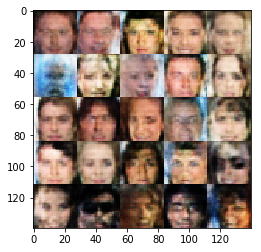

Epoch 1/1, iteration 3010: Discriminator Loss: 1.1530, Generator Loss: 0.8310
Epoch 1/1, iteration 3020: Discriminator Loss: 1.0475, Generator Loss: 1.0001
Epoch 1/1, iteration 3030: Discriminator Loss: 1.1650, Generator Loss: 0.8539
Epoch 1/1, iteration 3040: Discriminator Loss: 1.3483, Generator Loss: 0.6962
Epoch 1/1, iteration 3050: Discriminator Loss: 1.2030, Generator Loss: 0.8615
Epoch 1/1, iteration 3060: Discriminator Loss: 1.3723, Generator Loss: 0.6816
Epoch 1/1, iteration 3070: Discriminator Loss: 1.4499, Generator Loss: 0.7593
Epoch 1/1, iteration 3080: Discriminator Loss: 1.3647, Generator Loss: 0.9245
Epoch 1/1, iteration 3090: Discriminator Loss: 1.2994, Generator Loss: 0.8285
Epoch 1/1, iteration 3100: Discriminator Loss: 1.3174, Generator Loss: 0.7596


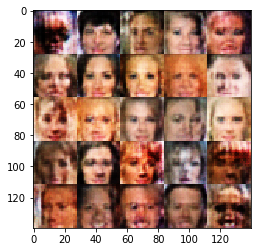

Epoch 1/1, iteration 3110: Discriminator Loss: 1.1975, Generator Loss: 1.0584
Epoch 1/1, iteration 3120: Discriminator Loss: 1.2167, Generator Loss: 1.2213
Epoch 1/1, iteration 3130: Discriminator Loss: 1.2943, Generator Loss: 0.8474
Epoch 1/1, iteration 3140: Discriminator Loss: 1.3272, Generator Loss: 0.7020
Epoch 1/1, iteration 3150: Discriminator Loss: 1.2413, Generator Loss: 0.7670
Epoch 1/1, iteration 3160: Discriminator Loss: 1.2070, Generator Loss: 1.0049


ValueError: Parent directory of ./checkpoints/generator.ckpt doesn't exist, can't save.

In [19]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.